In [19]:
from polygon import RESTClient
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import time

# Replace with your Polygon API key
# API_KEY = 'InxdvvQ5aFMwk5xWUpJUCpe8YHcimh8d'
API_KEY = 'hh0mSNz8kJH3asJCwAscTrtLt4RYb5RM'


def fetch_data(symbol, multiplier, timespan, from_date, to_date):
    client = RESTClient("InxdvvQ5aFMwk5xWUpJUCpe8YHcimh8d")
    aggs = client.get_aggs(symbol, multiplier, timespan, from_date, to_date)
    
    timestamps = []
    open_prices = []
    high_prices = []
    low_prices = []
    close_prices = []
    volumes = []
    
    for agg in aggs:
        timestamps.append(datetime.fromtimestamp(agg.timestamp // 1000))
        open_prices.append(agg.open)
        high_prices.append(agg.high)
        low_prices.append(agg.low)
        close_prices.append(agg.close)
        volumes.append(agg.volume)
        
    data = {
        't': timestamps,
        'o': open_prices,
        'h': high_prices,
        'l': low_prices,
        'c': close_prices,
        'v': volumes
    }
    
    df = pd.DataFrame(data)
    return df

def fetch_and_aggregate_data(symbol, from_date, to_date):
    df_1min = fetch_data(symbol, 1, 'minute', from_date, to_date)
    df_1min.set_index('t', inplace=True)
    df_5min = df_1min.resample('5T').agg({
        'o': 'first',
        'h': 'max',
        'l': 'min',
        'c': 'last',
        'v': 'sum'
    }).dropna().reset_index()
    return df_1min.reset_index(), df_5min

def calculate_fibonacci_levels(first_hour_df):
    high = first_hour_df['h'].max()
    low = first_hour_df['l'].min()
    
    diff = high - low
    levels = {
        '0%': low,
        '23.6%': low + 0.236 * diff,
        '38.2%': low + 0.382 * diff,
        '50%': low + 0.5 * diff,
        '61.8%': low + 0.618 * diff,
        '100%': high
    }
    return levels

def identify_choch(df, window_size=2):
    choch = []
    for i in range(window_size, len(df)):
        avg_prev_close = df['c'].iloc[i-window_size:i].mean()
        if df['c'].iloc[i] > avg_prev_close and df['c'].iloc[i-1] <= avg_prev_close:
            choch.append('CHOCH Up')
        elif df['c'].iloc[i] < avg_prev_close and df['c'].iloc[i-1] >= avg_prev_close:
            choch.append('CHOCH Down')
        else:
            choch.append(None)
    df['CHOCH'] = [None] * window_size + choch
    return df

def generate_signals(df, levels):
    signals = []
    touched_level = None

    for i in range(len(df)):
        signal = 'Hold'
        if i < 13:
            signals.append(signal)
            continue
        
        for level_name, level_price in levels.items():
            if abs(df['c'].iloc[i] - level_price) < 0.01:
                touched_level = level_name
                break
        
        if touched_level in ['50%', '61.8%'] and df['CHOCH'].iloc[i] == 'CHOCH Up':
            signal = 'Buy'
        elif df['c'].iloc[i] < levels['50%'] and df['CHOCH'].iloc[i] == 'CHOCH Down':
            signal = 'Sell'
        elif touched_level in ['50%', '61.8%'] and df['CHOCH'].iloc[i] == 'CHOCH Down':
            signal = 'Sell'
        elif df['c'].iloc[i] > levels['50%'] and df['CHOCH'].iloc[i] == 'CHOCH Up':
            signal = 'Buy'
        
        signals.append(signal)
        if signal in ['Buy', 'Sell']:
            touched_level = None
    
    df['Signal'] = signals
    return df

def plot_signals(df, levels):
    fig, ax = plt.subplots(figsize=(14, 7))
    fib_colors = ['g', 'b', 'r', 'c', 'm', 'y']
    
    ax.plot(df['t'], df['c'], color='black', label='Close')
    buy_signals = df[df['Signal'] == 'Buy']
    sell_signals = df[df['Signal'] == 'Sell']
    ax.scatter(buy_signals['t'], buy_signals['c'], marker='^', s=100, color='green', label='Buy Signal')
    ax.scatter(sell_signals['t'], sell_signals['c'], marker='v', s=100, color='red', label='Sell Signal')
    
    for i, (level, price) in enumerate(levels.items()):
        color = fib_colors[i % len(fib_colors)]
        ax.hlines(price, xmin=df['t'].iloc[0], xmax=df['t'].iloc[-1], colors=color, linestyles='--', label=f'Fibonacci {level}')
    
    ax.set_title('Fibonacci Retracement Trading Signals with CHOCH')
    ax.set_ylabel('Price')
    ax.legend()
    
    plt.show()
    
def generate_date_array(year):
    dates = []
    # Start from the first day of the given year
    current_date = datetime(year, 1, 1)
    # End on the last day of the given year
    end_date = datetime(year + 1, 1, 1)
    
    while current_date < end_date:
        # Format the date as "yyyy-mm-dd" and add it to the list
        date_string = current_date.strftime("%Y-%m-%d")
        dates.append(date_string)
        # Move to the next day
        current_date += timedelta(days=1)
    
    return dates
def graph_profits(data, type_of_profit):
    # Extract keys and values
    dates = list(data.keys())
    values = list(data.values())

    # Convert string dates to datetime objects
    dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

    # Create a plot
    plt.figure(figsize=(8, 4))
    plt.plot(dates, values, marker='o', linestyle='-', color='b')

    # Format the x-axis to show dates properly
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())

    # Label the axes
    plt.xlabel('Date')
    plt.ylabel(type_of_profit)
    plt.title(f'Model {type_of_profit} vs Holding Stock')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()


In [20]:
def fib_choch_strategy(ticker, df_1m, df_5m, start_date, end_date, cash=100000, shares=1000, percent_invest=20):
    df_1min, df_5min = df_1m, df_5m
    first_hour_df = df_5min.iloc[:12]
    levels = calculate_fibonacci_levels(first_hour_df)
    df_5min = identify_choch(df_5min)
    df_5min = generate_signals(df_5min, levels)

    transaction_times = df_5min[df_5min['Signal'].isin(['Buy', 'Sell'])][['t', 'Signal', 'c']].values.tolist()
    
    portfolio_val_s = cash + df_1min['c'].iloc[0] * shares
    amt = portfolio_val_s * percent_invest / 100

    print("Running Simulation for Fibbonacci with", ticker, "from", start_date, "to", end_date)
    print("Number of Transactions: ", len(transaction_times))
    print("Open Price, Close Price: ", df_1min['c'].iloc[0], df_1min['c'].iloc[-1])

    print("Initial Cash and Shares: ", cash, shares)
    print("Beginning Portfolio Value: ", portfolio_val_s)

    shares_s = shares

    for order in transaction_times:
        signal_time, signal, price = order
        next_time = signal_time + timedelta(minutes=1)
        
        if next_time not in df_1min['t'].values:
            continue
        
        next_price = df_1min.loc[df_1min['t'] == next_time, 'c'].values[0]

        if signal == 'Buy':
            cash -= amt
            shares += amt / next_price
        elif signal == 'Sell':
            cash += amt
            shares -= amt / next_price
        #print(signal, cash, shares)

    portfolio_val_e = cash + df_1min['c'].iloc[-1] * shares
    profit = portfolio_val_e - portfolio_val_s

    profit_percentage = (profit / portfolio_val_s) * 100
    base_profit_percentage = shares_s*(df_1min['c'].iloc[-1]-df_1min['c'].iloc[0])/portfolio_val_s * 100
    
    
    print("End Cash and Shares: ", cash, shares)
    print("End Portfolio Value: ", portfolio_val_e)
    print("Profit: ", profit, profit_percentage, "%")
    print("Market Change w/o trades", base_profit_percentage)

    print("Model outperforms market by", profit_percentage - base_profit_percentage)
    
    plot_signals(df_5min, levels)
    
    return [cash, shares, profit, profit_percentage, base_profit_percentage]

In [27]:
def test_model(ticker, df_1min , df_5min, start_date, end_date, init_cash, init_shares, percent_invest):
    year1 = int(start_date[:4])
    year2 = int(end_date[:4])
    date_array = []
    for year in range(year1, year2+1):
        date_array += generate_date_array(year)

    cash, shares, profit, profit_percentage, base_profit_percentage = fib_choch_strategy(ticker, df_1min, df_5min, start_date, end_date, init_cash, init_shares, percent_invest)
    alpha = profit_percentage - base_profit_percentage

    return alpha, profit_percentage

alphas_dict = {}
top_25_tickers = [
    "AAPL",  # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "GOOGL", # Alphabet Inc. (Class A)
    "GOOG",  # Alphabet Inc. (Class C)
    "AMZN",  # Amazon.com Inc.
    "TSLA",  # Tesla Inc.
    "NVDA",  # NVIDIA Corporation
    "BRK.B", # Berkshire Hathaway Inc. (Class B)
    "META",  # Meta Platforms, Inc.
    "UNH",   # UnitedHealth Group Incorporated
    "JNJ",   # Johnson & Johnson
    "V",     # Visa Inc.
    "WMT",   # Walmart Inc.
    "XOM",   # Exxon Mobil Corporation
    "PG",    # Procter & Gamble Co.
    "JPM",   # JPMorgan Chase & Co.
    "MA",    # Mastercard Incorporated
    "LLY",   # Eli Lilly and Company
    "HD",    # The Home Depot, Inc.
    "CVX",   # Chevron Corporation
    "MRK",   # Merck & Co., Inc.
    "PEP",   # PepsiCo, Inc.
    "ABBV",  # AbbVie Inc.
    "KO",    # The Coca-Cola Company
    "SPY"    # S&P 500
]

Invest RSI for AAPL from 2024-07-01 to 2024-07-02
Running Simulation for Fibbonacci with AAPL from 2024-07-01 to 2024-07-02
Number of Transactions:  74
Open Price, Close Price:  211.84 219.41
Initial Cash and Shares:  500000.0 2359.7149464344707
Beginning Portfolio Value:  999882.0142526783
End Cash and Shares:  -49935.10783897273 4890.352839470371
End Portfolio Value:  1023057.2086692213
Profit:  23175.194416543003 2.3177929081827093 %
Market Change w/o trades 1.7865149977580046
Model outperforms market by 0.5312779104247047


/var/folders/7h/2c8x9dcj2q945s1l06p8l38r0000gn/T/ipykernel_58147/4134579414.py:46: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_5min = df_1min.resample('5T').agg({


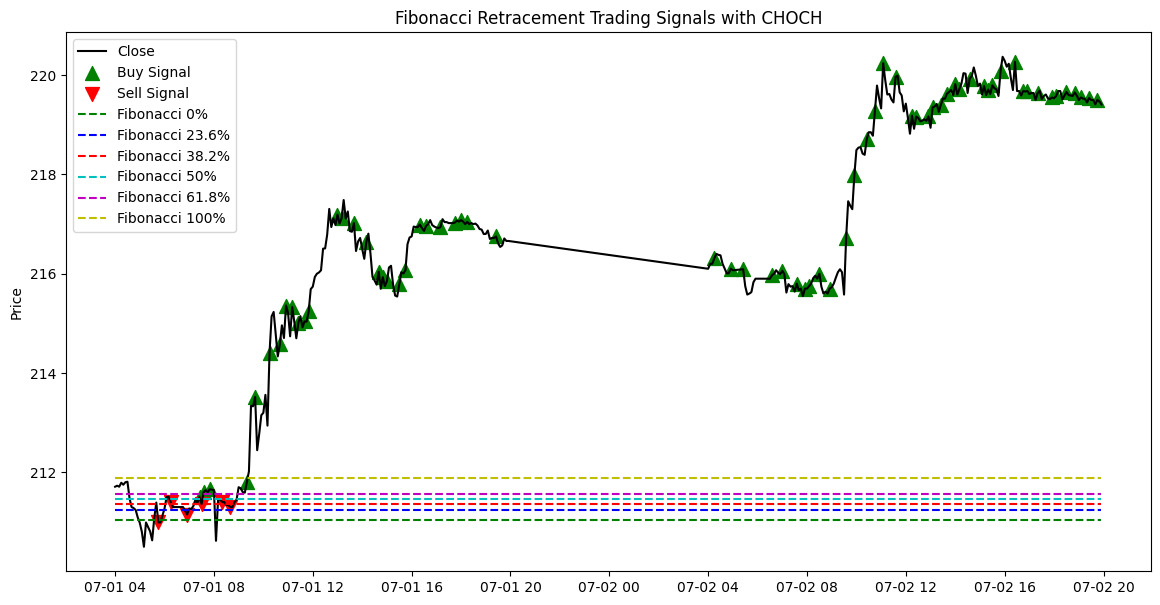



Invest RSI for MSFT from 2024-07-01 to 2024-07-02
Running Simulation for Fibbonacci with MSFT from 2024-07-01 to 2024-07-02
Number of Transactions:  61
Open Price, Close Price:  447.85 459.1
Initial Cash and Shares:  500000.0 1115.0758251561106
Beginning Portfolio Value:  999386.7082961642
End Cash and Shares:  120233.05084745731 1948.9876078739658
End Portfolio Value:  1015013.2616223951
Profit:  15626.553326230962 1.5636142842916514 %
Market Change w/o trades 1.2552301255230125
Model outperforms market by 0.3083841587686389


/var/folders/7h/2c8x9dcj2q945s1l06p8l38r0000gn/T/ipykernel_58147/4134579414.py:46: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_5min = df_1min.resample('5T').agg({


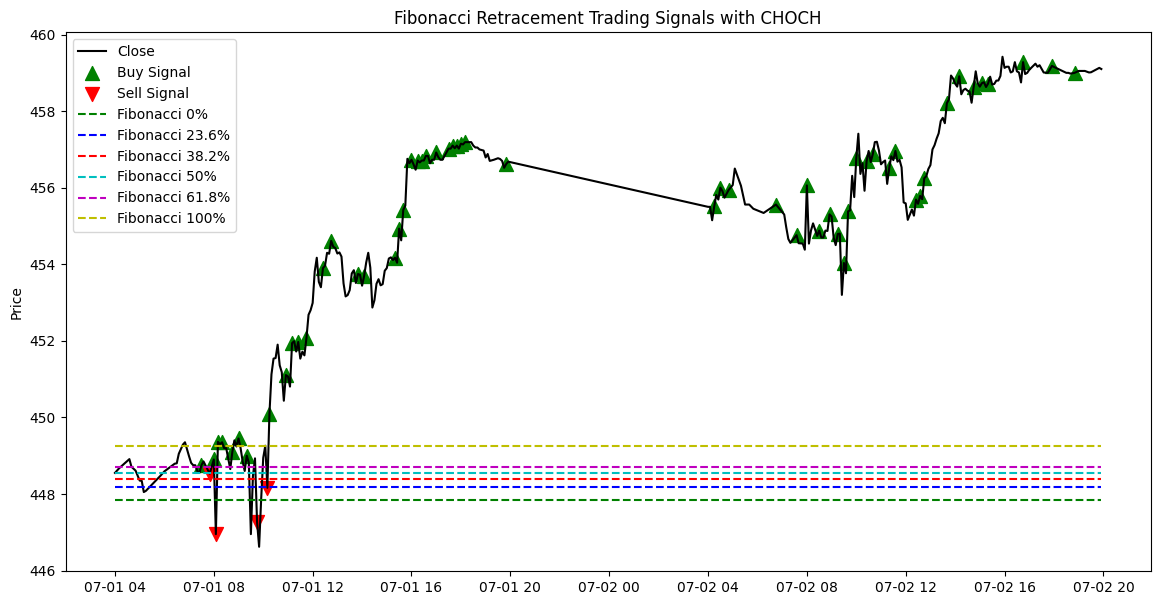



Invest RSI for GOOGL from 2024-07-01 to 2024-07-02
Running Simulation for Fibbonacci with GOOGL from 2024-07-01 to 2024-07-02
Number of Transactions:  68
Open Price, Close Price:  182.28 185.25
Initial Cash and Shares:  500000.0 2743.032696949748
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  390000.0 3336.5494641820005
End Portfolio Value:  1008095.7882397156
Profit:  8095.788239715621 0.809578823971562 %
Market Change w/o trades 0.8146807109940748
Model outperforms market by -0.005101887022512797


/var/folders/7h/2c8x9dcj2q945s1l06p8l38r0000gn/T/ipykernel_58147/4134579414.py:46: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_5min = df_1min.resample('5T').agg({


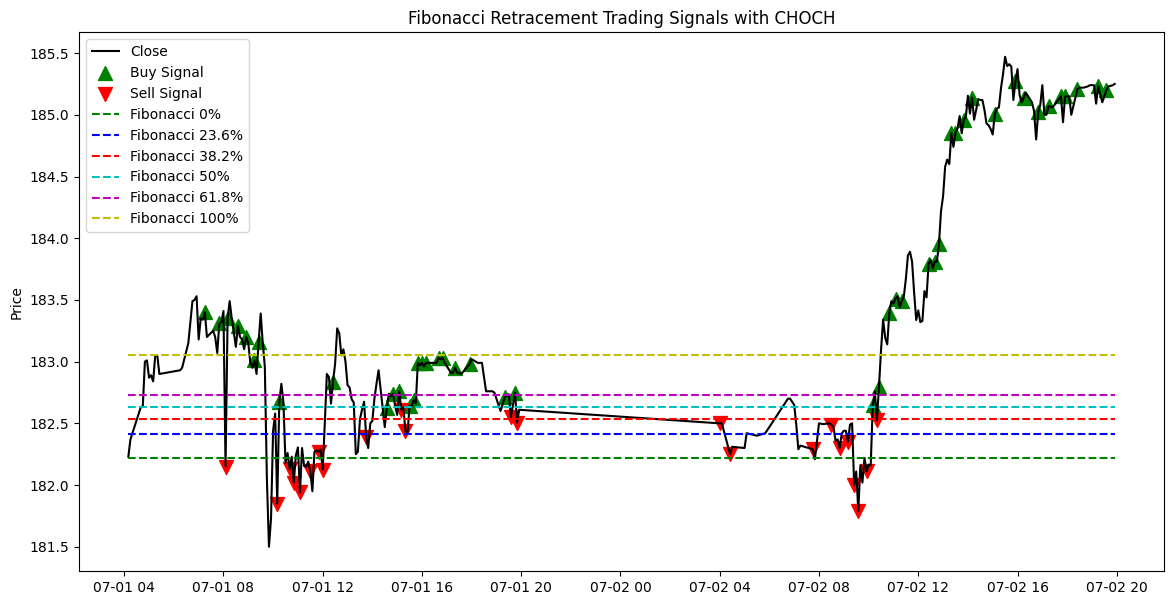



Invest RSI for GOOG from 2024-07-01 to 2024-07-02
Running Simulation for Fibbonacci with GOOG from 2024-07-01 to 2024-07-02
Number of Transactions:  56
Open Price, Close Price:  183.61 186.61
Initial Cash and Shares:  500000.0 2723.1632264037903
Beginning Portfolio Value:  1000000.0
End Cash and Shares:  360000.0 3473.9968184423665
End Portfolio Value:  1008282.54628953
Profit:  8282.54628953 0.8282546289530001 %
Market Change w/o trades 0.816948967921137
Model outperforms market by 0.011305661031863035


/var/folders/7h/2c8x9dcj2q945s1l06p8l38r0000gn/T/ipykernel_58147/4134579414.py:46: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_5min = df_1min.resample('5T').agg({


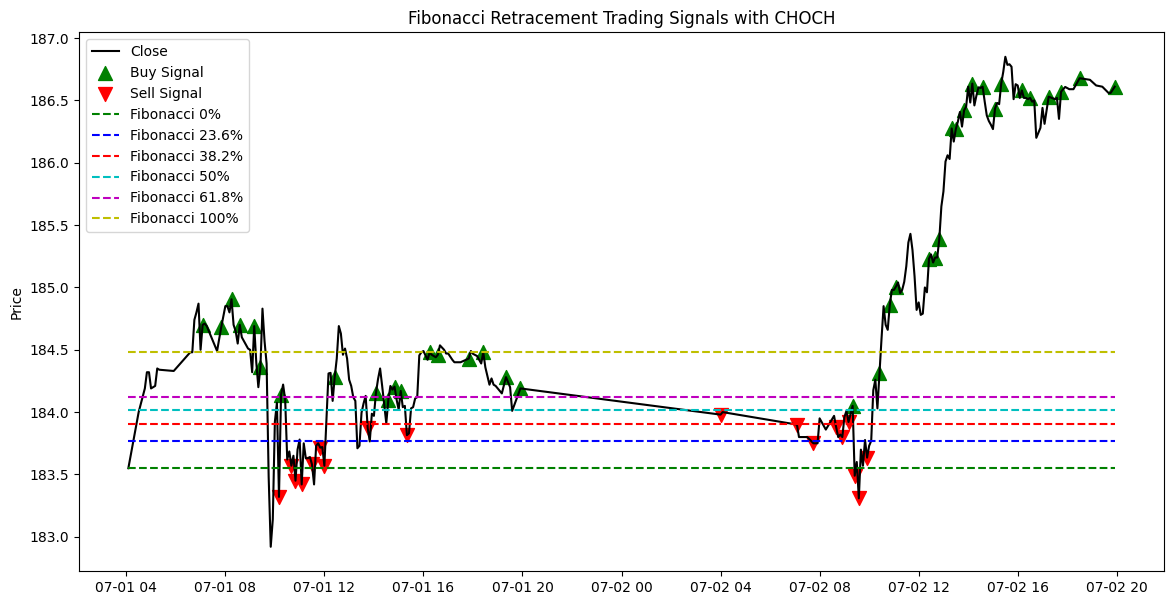



Invest RSI for AMZN from 2024-07-01 to 2024-07-02
Running Simulation for Fibbonacci with AMZN from 2024-07-01 to 2024-07-02
Number of Transactions:  71
Open Price, Close Price:  194.52 200.02
Initial Cash and Shares:  500000.0 2572.1487730850354
Beginning Portfolio Value:  1000334.379340501
End Cash and Shares:  39846.18550336995 4898.7562388138485
End Portfolio Value:  1019695.408390916
Profit:  19361.029050414916 1.935455728631383 %
Market Change w/o trades 1.4142089429430973
Model outperforms market by 0.5212467856882856


/var/folders/7h/2c8x9dcj2q945s1l06p8l38r0000gn/T/ipykernel_58147/4134579414.py:46: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_5min = df_1min.resample('5T').agg({


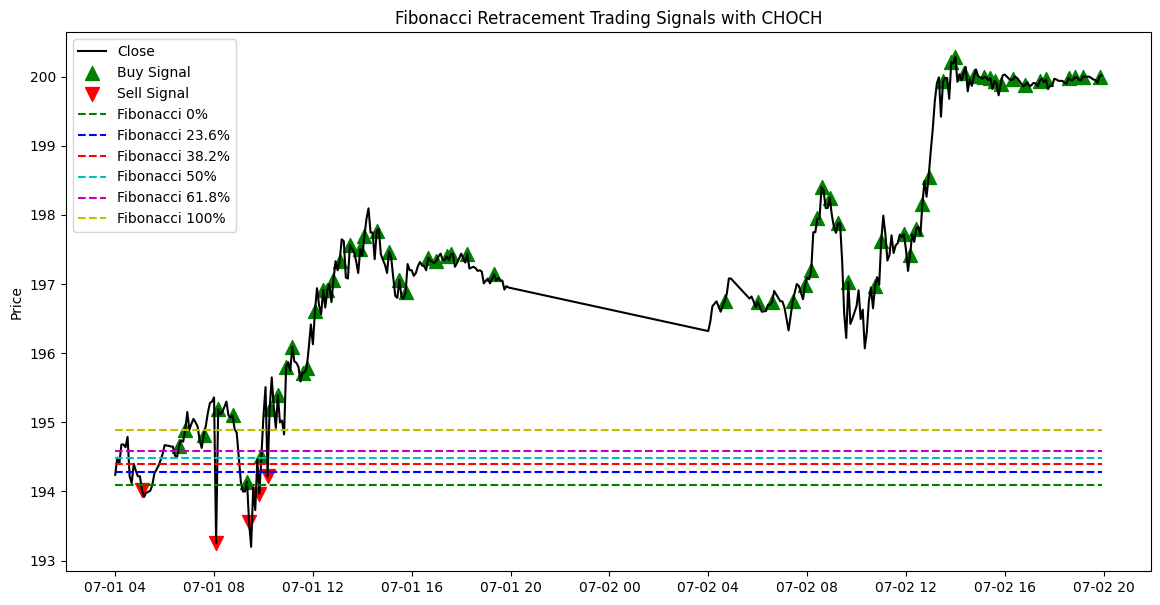



Alphas for each stock: {'AAPL': 0.5312779104247047, 'MSFT': 0.3083841587686389, 'GOOGL': -0.005101887022512797, 'GOOG': 0.011305661031863035, 'AMZN': 0.5212467856882856}


In [29]:
tickers = top_25_tickers[:5]
start_date = "2024-07-01"
end_date =  "2024-07-02"
initial_portfolio_value = 1000000
count = 0

for ticker in tickers:
    if count % 5 == 0 and count != 0:
        print("Waiting for 60 seconds to avoid rate limit")
        time.sleep(60)
    count += 1
        

    print("Invest RSI for", ticker, "from" , start_date, "to" , end_date)
    
    df_1min, df_5min = fetch_and_aggregate_data(ticker, start_date, end_date)

    # replace start price with start price of stock (you can find it in yahoo finance)
    start_price = df_1min["o"][0]
   
    initial_cash = 0.5 * initial_portfolio_value
    initial_shares = (0.5 * initial_portfolio_value/start_price) if start_price > 0 else 1000
    percent_invest = 1
    alpha, profit = test_model(ticker, df_1min, df_5min, start_date, end_date, initial_cash, initial_shares, percent_invest) # can only run for about 1.5 yrs
    alphas_dict[ticker] = alpha
    print()
    print()
    

print("Alphas for each stock:", alphas_dict)

Average Alpha:  0.27342252577819587


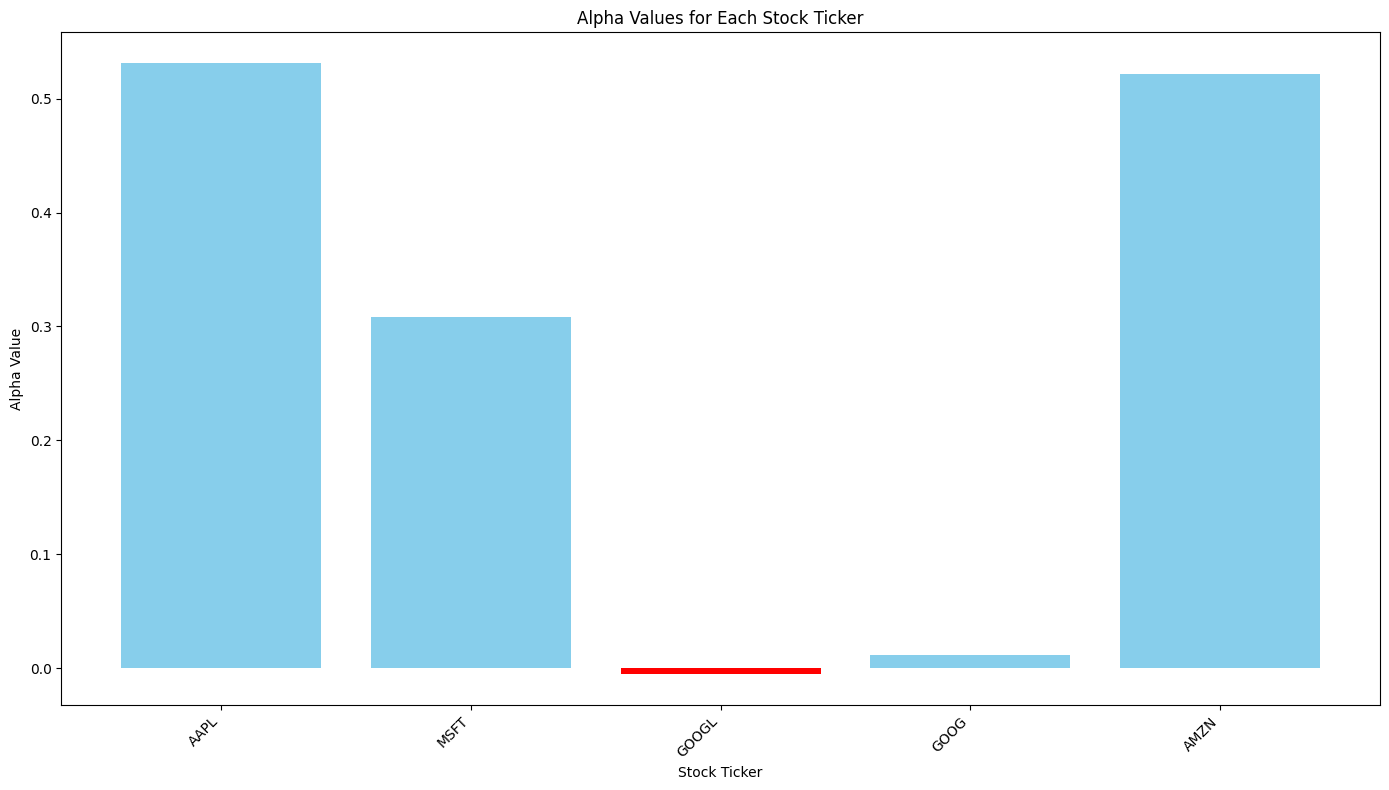

In [30]:
# Create lists of tickers and corresponding alphas
tickers = list(alphas_dict.keys())
alphas = list(alphas_dict.values())
print("Average Alpha: ", sum(alphas)/len(alphas))

colors = ['red' if alpha < 0 else 'skyblue' for alpha in alphas]  # Red for negative, blue for positive

# Plotting the data
plt.figure(figsize=(14, 8))
plt.bar(tickers, alphas, color=colors)

# Labels and title
plt.xlabel('Stock Ticker')
plt.ylabel('Alpha Value')
plt.title('Alpha Values for Each Stock Ticker')

# Rotate the x labels for better readability
plt.xticks(rotation=45, ha='right')


# Show the plot
plt.tight_layout()
plt.show()